In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import torch.nn.functional as F
from matrepr import mdisplay
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from torch.utils.data import DataLoader

from analysis.common import load_autoencoder, load_model
from koopmann.data import (
    DatasetConfig,
    get_dataset_class,
)
from koopmann.utils import (
    get_device,
)
from koopmann.visualization import plot_eigenvalues
from scripts.train_ae.losses import pad_act

%load_ext autoreload
%autoreload 2

In [2]:
file_dir = "/scratch/nsa325/koopmann_model_saves"
dim = 2048
k = 1
scale_idx = 1

rank = 10
flavor = f"lowrank_{rank}"
# flavor = "standard"
# flavor = "exponential"

model_name = "resmlp"
ae_name = f"dim_{dim}_k_{k}_loc_{scale_idx}_{flavor}_autoencoder_mnist_model"
device = get_device()

In [3]:
model, model_metadata = load_model(file_dir, model_name)
model.hook_model().eval()
print(model_metadata)

{'batchnorm': True, 'bias': False, 'created_at': '2025-03-11T02:31:07.086062', 'dataset': 'MNISTDataset', 'hidden_config': [512, 512, 512, 512], 'in_features': 784, 'model_class': 'ResMLP', 'nonlinearity': 'relu', 'out_features': 10, 'stochastic_depth_mode': 'batch', 'stochastic_depth_prob': 0.0}


In [4]:
# Dataset config
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"],
    num_samples=3_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = DataLoader(dataset, batch_size=10_000)

In [5]:
autoencoder, ae_metadata = load_autoencoder(file_dir, ae_name)
autoencoder.eval()
K_matrix = autoencoder.koopman_weights.T.detach()

In [6]:
# px.imshow(K_matrix)

(<Figure size 400x400 with 1 Axes>,
 array([<Axes: title={'center': '$k=1$, $dim=2048$'}>], dtype=object))

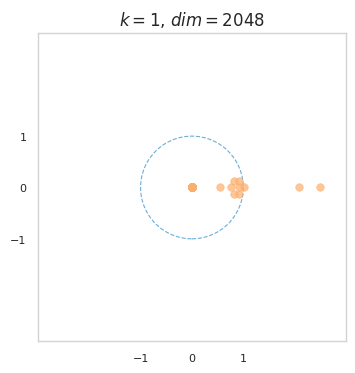

In [7]:
eigenvalues, eigenvectors = torch.linalg.eig(K_matrix)
plot_eigenvalues({(k, dim): eigenvalues}, axis=[-3, 3])

In [8]:
images, labels = next(iter(dataloader))
sample_idx = torch.randint(1024, (1,))[0].item()

with torch.no_grad():
    x = images.flatten(start_dim=1)
    _ = model(x)
    act_dict = model.get_forward_activations(detach=True)

    input_dict = {0: pad_act(x, autoencoder.components.encoder[0].in_channels)}
    for key, val in act_dict.items():
        input_dict[key + 1] = val

    input_list = list(input_dict.values())

    x = input_list[scale_idx]
    y = input_list[-2]
    x_obs = autoencoder.encode(x)
    y_obs = autoencoder.encode(y)
    x_pred = x_obs @ autoencoder.koopman_weights.T


In [9]:
def visualize_transformations(
    eigvals,
    eigvecs,
    x_obs,
    labels=None,
    threshold=1e-5,
    max_spaces=3,
    show_transform=True,
    include_random=False,
):
    if labels is not None:
        labels = labels.flatten()

    sig_idx = [i for i, v in enumerate(eigvals) if torch.abs(v) > threshold]
    if not sig_idx:
        return None

    real_idx, complex_pairs = [], []
    i = 0
    while i < len(sig_idx):
        idx = sig_idx[i]
        if torch.abs(torch.imag(eigvals[idx])) < threshold:
            real_idx.append(idx)
            i += 1
        elif i + 1 < len(sig_idx) and torch.isclose(eigvals[idx], eigvals[sig_idx[i + 1]].conj()):
            complex_pairs.append((idx, sig_idx[i + 1]))
            i += 2
        else:
            i += 1

    real_pairs = [(real_idx[i], real_idx[i + 1]) for i in range(0, len(real_idx) - 1, 2)]
    if len(real_idx) % 2:
        real_pairs.append((real_idx[-1],))

    spaces = (complex_pairs + real_pairs)[:max_spaces]
    plot_count = len(spaces) + (1 if include_random else 0)
    fig, axes = plt.subplots(1, plot_count, figsize=(5 * plot_count, 5))
    axes = [axes] if plot_count == 1 else axes

    for ax, idx in zip(axes[: len(spaces)], spaces):
        is_complex = len(idx) > 1 and torch.abs(torch.imag(eigvals[idx[0]])) > threshold
        if len(idx) == 1:
            plot_single_real(eigvals[idx[0]], eigvecs[:, idx[0]], x_obs, labels, ax, show_transform)
        elif is_complex:
            plot_complex(eigvals[idx[0]], eigvecs[:, idx[0]], x_obs, labels, ax, show_transform)
        else:
            plot_real_pair(
                eigvals[idx[0]],
                eigvals[idx[1]],
                eigvecs[:, idx[0]],
                eigvecs[:, idx[1]],
                x_obs,
                labels,
                ax,
                show_transform,
            )

    if include_random:
        plot_random_projection(x_obs, labels, axes[-1])

    plt.tight_layout()
    return fig


def plot_points(before, after=None, labels=None, ax=None, arrows=5, show_transform=True):
    pts_to_plot = before if after is None or not show_transform else torch.cat([before, after])
    for dim in [0, 1]:
        r = max(0.1, pts_to_plot[:, dim].max() - pts_to_plot[:, dim].min())
        ax.set_xlim(pts_to_plot[:, 0].min() - 0.1 * r, pts_to_plot[:, 0].max() + 0.1 * r)
        ax.set_ylim(pts_to_plot[:, 1].min() - 0.1 * r, pts_to_plot[:, 1].max() + 0.1 * r)

    if labels is not None:
        for lbl in torch.unique(labels):
            mask = labels == lbl
            b = before[mask].numpy()
            ax.scatter(b[:, 0], b[:, 1], marker="o", s=40, alpha=0.6, label=f"Class {lbl.item()}")

            if show_transform and after is not None:
                a = after[mask].numpy()
                ax.scatter(a[:, 0], a[:, 1], marker="x", s=60, alpha=0.8)

                if len(b) > 0:
                    for i in np.random.choice(len(b), min(arrows, len(b)), replace=False):
                        ax.arrow(
                            b[i, 0],
                            b[i, 1],
                            a[i, 0] - b[i, 0],
                            a[i, 1] - b[i, 1],
                            width=0.005,
                            head_width=0.02,
                            alpha=0.4,
                        )
    else:
        b = before.numpy()
        label = "Projection" if not show_transform else "Before"
        ax.scatter(b[:, 0], b[:, 1], c="blue", marker="o", s=40, alpha=0.6, label=label)

        if show_transform and after is not None:
            a = after.numpy()
            ax.scatter(a[:, 0], a[:, 1], c="red", marker="x", s=60, alpha=0.8, label="After")

    ax.axhline(y=0, color="k", alpha=0.2)
    ax.axvline(x=0, color="k", alpha=0.2)
    ax.grid(alpha=0.2)
    ax.set_aspect("equal")
    ax.legend(loc="upper right")


def plot_random_projection(x_obs, labels, ax):
    n_samples, n_features = x_obs.shape
    v1 = torch.randn(n_features)
    v2 = torch.randn(n_features)
    v2 = v2 - v1 * torch.dot(v2, v1) / torch.dot(v1, v1)
    v1, v2 = v1 / torch.norm(v1), v2 / torch.norm(v2)

    p1, p2 = torch.matmul(x_obs, v1), torch.matmul(x_obs, v2)
    projection = torch.stack([p1, p2], dim=1)
    plot_points(projection, None, labels, ax, show_transform=False)

    ax.set_title("Random Projection")
    ax.set_xlabel("Random Direction 1")
    ax.set_ylabel("Random Direction 2")
    return projection


def plot_complex(eigval, eigvec, x_obs, labels, ax, show_transform=True):
    u1 = torch.real(eigvec) / torch.norm(torch.real(eigvec))
    u2 = torch.imag(eigvec) / torch.norm(torch.imag(eigvec))
    mag, ang = torch.abs(eigval), torch.angle(eigval)

    p1, p2 = torch.matmul(x_obs, u1), torch.matmul(x_obs, u2)
    before = torch.stack([p1, p2], dim=1)
    rot_matrix = mag * torch.tensor(
        [[torch.cos(ang), -torch.sin(ang)], [torch.sin(ang), torch.cos(ang)]]
    )
    after = torch.matmul(before, rot_matrix.T)

    plot_points(before, after, labels, ax, show_transform=show_transform)

    title = (
        f"Complex λ={eigval.item():.3f}\n|λ|={mag.item():.2f}, ∠={np.degrees(ang.item()):.0f}°"
        if show_transform
        else f"Projection onto complex eigenvector\nλ={eigval.item():.3f}"
    )
    ax.set_title(title)
    ax.set_xlabel("Real component")
    ax.set_ylabel("Imaginary component")


def plot_real_pair(lambda1, lambda2, v1, v2, x_obs, labels, ax, show_transform=True):
    v1 = torch.real(v1) if torch.is_complex(v1) else v1
    v2 = torch.real(v2) if torch.is_complex(v2) else v2
    v1, v2 = v1 / torch.norm(v1), v2 / torch.norm(v2)

    p1, p2 = torch.matmul(x_obs, v1), torch.matmul(x_obs, v2)
    before = torch.stack([p1, p2], dim=1)
    after = torch.zeros_like(before)
    after[:, 0], after[:, 1] = before[:, 0] * lambda1.real, before[:, 1] * lambda2.real

    plot_points(before, after, labels, ax, show_transform=show_transform)

    title = (
        f"Real λ1={lambda1.item():.3f}, λ2={lambda2.item():.3f}"
        if show_transform
        else "Projection onto real eigenvectors"
    )
    ax.set_title(title)
    ax.set_xlabel("Eigenvector 1")
    ax.set_ylabel("Eigenvector 2")


def plot_single_real(lambda1, v1, x_obs, labels, ax, show_transform=True):
    v1 = torch.real(v1) if torch.is_complex(v1) else v1
    v1 = v1 / torch.norm(v1)

    v2 = torch.zeros_like(v1)
    for i in range(len(v1)):
        if torch.abs(v1[i]) > 1e-6:
            v2[i if i > 0 else 1] = 1.0
            v2 = v2 - v1 * torch.dot(v2, v1)
            v2 = v2 / torch.norm(v2)
            break

    p1, p2 = torch.matmul(x_obs, v1), torch.matmul(x_obs, v2)
    before = torch.stack([p1, p2], dim=1)
    after = before.clone()
    after[:, 0] = before[:, 0] * lambda1.real

    plot_points(before, after, labels, ax, show_transform=show_transform)

    title = f"Real λ={lambda1.item():.3f}" if show_transform else "Projection onto real eigenvector"
    ax.set_title(title)
    ax.set_xlabel("Eigenvector")
    ax.set_ylabel("Orthogonal direction")


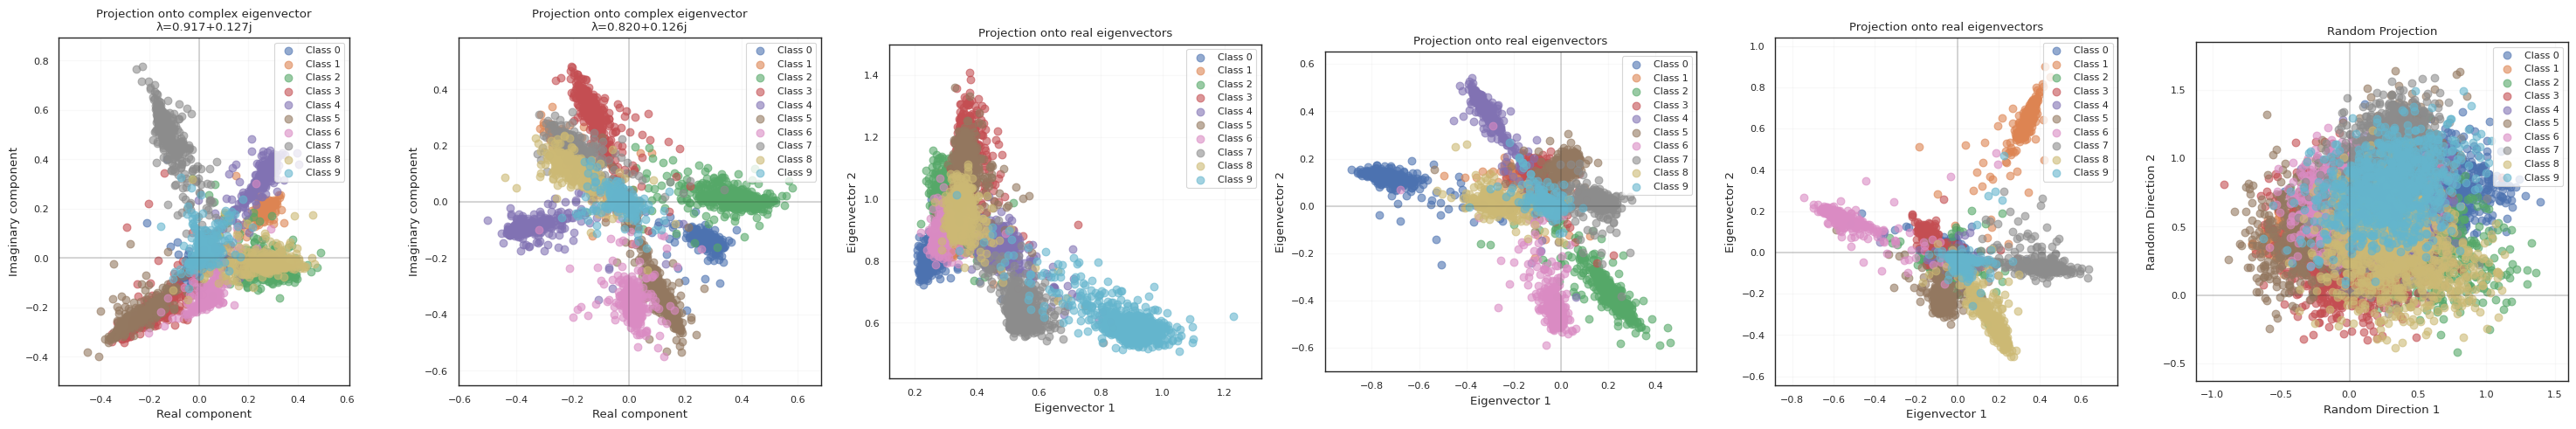

In [10]:
fig = visualize_transformations(
    eigenvalues,
    eigenvectors,
    x_obs,
    labels,
    threshold=1e-3,
    max_spaces=5,
    show_transform=False,
    include_random=True,
)

Model accuracy 98.97000122070312
Koopman decoder 98.97000122070312
Koopman prediction 98.62999725341797


/tmpdata/ipykernel_3867875/1609369621.py:87: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  x_trunc_pred = x_trunc_pred.to(torch.float32)


Ablate [0] 88.91999816894531
Ablate [1] 92.69000244140625
Ablate [2] 88.97000122070312
Ablate [3, 4] 87.91000366210938
Ablate [5] 85.02999877929688
Ablate [6, 7] 94.52999877929688
Ablate [8] 98.45999908447266
Ablate [9] 87.37999725341797


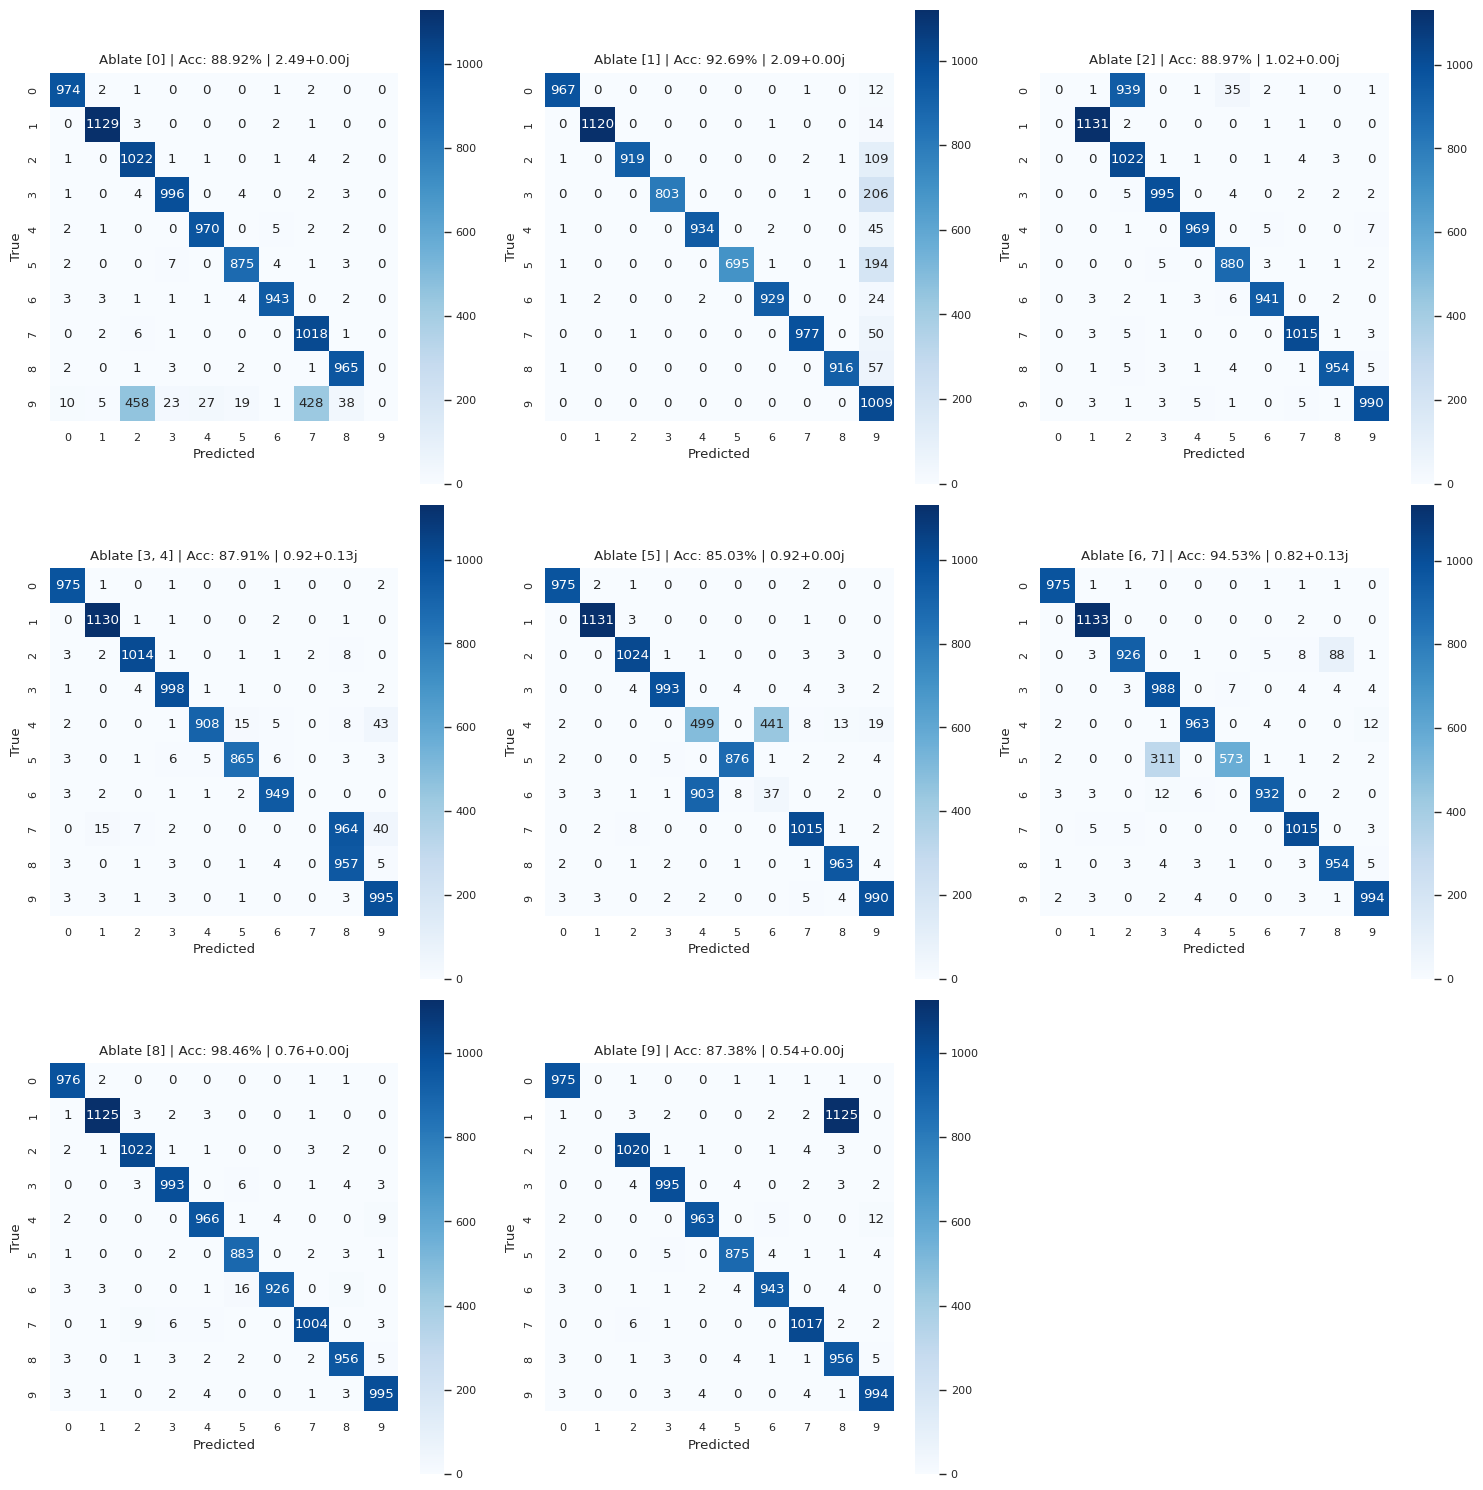

In [11]:
def accuracy(components, x, labels):
    total = len(labels)
    comp = [comp for comp in components]
    for comp in comp:
        if isinstance(x, tuple):
            x = x[0]
        x = comp(x)

    preds = torch.argmax(x, dim=1)
    correct = torch.sum(preds == labels)
    return preds, correct / total * 100


def find_eigenpairs(eigenvalues, eigenvectors):
    groups = []
    i = 0
    while i < len(eigenvalues):
        val = eigenvalues[i]
        if torch.abs(val.imag) < 1e-10:
            groups.append([i])
        else:
            groups.append([i, i + 1])
            i += 1
        i += 1

    return groups


def show_confusion(rank):
    with torch.no_grad():
        # Get forward acts
        x = images.flatten(start_dim=1)
        _ = model(x)
        act_dict = model.get_forward_activations(detach=True)
        input_dict = {0: pad_act(x, autoencoder.components.encoder[0].in_channels)}
        for key, val in act_dict.items():
            input_dict[key + 1] = val
        input_list = list(input_dict.values())

        # Use Koopman autoencoder
        x = input_list[scale_idx]
        y = input_list[-2]
        x_obs = autoencoder.encode(x)
        y_obs = autoencoder.encode(y)
        x_pred = x_obs @ autoencoder.koopman_weights.T
        decoder_preds, acc = accuracy(model.components[-1:], autoencoder.decode(x_pred), labels)

        # Accuracies
        model_acc = accuracy(model.components[1:], x, labels)[1].item()
        koopman_decoder_acc = accuracy(model.components[-1:], autoencoder.decode(y_obs), labels)[
            1
        ].item()
        koopman_pred_acc = acc.item()

        print("Model accuracy", model_acc)
        print("Koopman decoder", koopman_decoder_acc)
        print("Koopman prediction", koopman_pred_acc)

        # Spectral decomposition
        D, V = torch.linalg.eig(autoencoder.koopman_weights.T)
        Vh = torch.linalg.inv(V)
        magnitudes = torch.abs(D)

        # Sort by magnitude (descending)
        idx = torch.argsort(magnitudes, descending=True)
        D = D[idx]
        V = V[:, idx]
        Vh = torch.linalg.inv(V)

        # Iterative ablation
        all_idx = range(rank)
        pairs_idx = find_eigenpairs(D[:rank], V[:rank])

        num_pairs = len(pairs_idx)
        cols = min(3, num_pairs)  # Max 3 columns for readability
        rows = (num_pairs + cols - 1) // cols  # Compute rows dynamically

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), squeeze=False)
        axes = axes.flatten()  # Flatten to ensure indexing works

        ablation_results = {}
        for i, idx in enumerate(pairs_idx):
            keep = list(set(all_idx) - set(idx))

            trunk_dynamics = V[:, keep] @ torch.diag(D[keep]) @ Vh[keep, :]
            x_trunc_pred = x_obs.type(torch.complex64) @ trunk_dynamics
            x_trunc_pred = x_trunc_pred.to(torch.float32)

            preds, acc = accuracy(model.components[-1:], autoencoder.decode(x_trunc_pred), labels)
            acc_value = acc.item()
            print(f"Ablate {idx}", acc_value)

            # Get class predictions (assuming preds contains logits/probabilities)
            np_preds = preds.cpu().numpy()
            np_labels = labels.cpu().numpy()

            # Create and plot confusion matrix
            cm = confusion_matrix(np_labels, np_preds)
            ablation_results[idx[0]] = (cm, acc.item())
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], square=True)
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")
            axes[i].set_title(f"Ablate {idx} | Acc: {acc_value:.2f}% | {D[idx[0]]:.2f}")

        # Hide unused subplots if necessary
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # Adjust layout
        plt.tight_layout()
        plt.show()
        return ablation_results


ablation_results = show_confusion(rank)

In [12]:
def analyze_koopman_modes(autoencoder, x_obs, labels, ablation_results=None, top_k=5):
    """Analyze relationship between Koopman eigenspace and classification behavior."""
    import numpy as np
    import torch
    from scipy.stats import entropy

    # Spectral decomposition
    D, V = torch.linalg.eig(autoencoder.koopman_weights.T)
    Vh = torch.linalg.inv(V)
    magnitudes = torch.abs(D)

    # Sort by magnitude (descending)
    idx = torch.argsort(magnitudes, descending=True)
    eigvals = D[idx]
    eigvecs = V[:, idx]

    # Compute class centroids in latent space
    classes = torch.unique(labels)
    centroids = {c.item(): x_obs[labels == c].mean(dim=0) for c in classes}

    # Analyze top eigenvectors
    modes = []
    for i in range(min(top_k, eigvecs.shape[1])):
        # Get the actual index in the sorted list
        eigen_idx = idx[i].item()

        # Handle complex eigenvalues
        is_complex = torch.abs(torch.imag(eigvals[i])) > 1e-10
        vec = (
            torch.real(eigvecs[:, i])
            if not is_complex
            else torch.view_as_real(eigvecs[:, i]).select(1, 0)
        )
        vec = vec / torch.norm(vec)

        # Compute decoder sensitivity
        base = autoencoder.decode(torch.zeros(1, eigvecs.shape[0], device=eigvecs.device))
        perturbed = autoencoder.decode(vec.unsqueeze(0))
        sensitivity = torch.norm(perturbed - base).item()

        # Class separability along this eigenvector
        projections = {c.item(): torch.matmul(x_obs[labels == c], vec) for c in classes}

        # Get confusion pattern when ablated
        confusion = None
        if ablation_results and eigen_idx in ablation_results:
            cm = ablation_results[eigen_idx][0]
            class_transitions = []
            for c_idx, true_class in enumerate(classes):
                if cm[c_idx].sum() < 5:
                    continue

                pred_dist = cm[c_idx].copy()
                pred_dist[c_idx] = 0

                if pred_dist.sum() > 0:
                    confused_idx = np.argmax(pred_dist)
                    rate = pred_dist[confused_idx] / cm[c_idx].sum()
                    if rate > 0.2:
                        class_transitions.append(
                            (true_class.item(), classes[confused_idx].item(), rate)
                        )
            confusion = class_transitions

        modes.append(
            {
                "index": eigen_idx,
                "eigenvalue": eigvals[i],
                "magnitude": magnitudes[idx[i]].item(),
                "sensitivity": sensitivity,
                "projections": projections,
                "confusion": confusion,
            }
        )

    # Sort by decoder sensitivity
    modes.sort(key=lambda x: x["sensitivity"], reverse=True)
    return modes


def print_analysis(modes):
    """Concise mathematical presentation of mode analysis."""
    print("Koopman Mode Analysis\n")
    for i, mode in enumerate(modes):
        print(
            f"Mode {mode['index']} | λ = {mode['eigenvalue']:.4f} | |λ| = {mode['magnitude']:.4f}"
        )
        print(f"Decoder sensitivity: {mode['sensitivity']:.4f}")

        if mode["confusion"]:
            print("Class transitions:")
            for true_c, pred_c, rate in mode["confusion"]:
                print(f"  {true_c} → {pred_c}: {rate*100:.1f}%")
        print()


# Usage
with torch.no_grad():
    modes = analyze_koopman_modes(autoencoder, x_obs, labels, ablation_results)
    print_analysis(modes)

Koopman Mode Analysis

Mode 1 | λ = 2.0872+0.0000j | |λ| = 2.0872
Decoder sensitivity: 0.2892
Class transitions:
  3 → 9: 20.4%
  5 → 9: 21.7%

Mode 0 | λ = 2.4888+0.0000j | |λ| = 2.4888
Decoder sensitivity: 0.1557
Class transitions:
  9 → 2: 45.4%

Mode 2 | λ = 1.0234+0.0000j | |λ| = 1.0234
Decoder sensitivity: 0.1032
Class transitions:
  0 → 2: 95.8%

Mode 3 | λ = 0.9167+0.1266j | |λ| = 0.9254
Decoder sensitivity: 0.0946
Class transitions:
  7 → 8: 93.8%

Mode 4 | λ = 0.9167-0.1266j | |λ| = 0.9254
Decoder sensitivity: 0.0946

